# Titanic — Model Comparison, Tuning & Interpretability
**Goal:** Compare classical ML models (Logistic Regression, RandomForest, HistGradientBoosting), tune the best (HGB) with `GridSearchCV`, and interpret the final model using built-in importances, permutation importance, and SHAP.

Dataset: `seaborn.load_dataset("titanic")` (convenient and similar to Kaggle Titanic).


In [19]:
# -----------------------
# 0) Imports & setup
# -----------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)

## 1) Load & inspect data

In [20]:
# load dataset
titanic = sns.load_dataset("titanic")
display(titanic.head())
print("\nMissing value fraction per column:\n")
print(titanic.isna().mean().sort_values(ascending=False).head(12))

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True



Missing value fraction per column:

deck           0.772166
age            0.198653
embarked       0.002245
embark_town    0.002245
survived       0.000000
pclass         0.000000
sex            0.000000
sibsp          0.000000
parch          0.000000
fare           0.000000
class          0.000000
who            0.000000
dtype: float64


**Feature selection** — we will keep a compact set of features that are commonly used:
`pclass`, `sex`, `age`, `sibsp`, `parch`, `fare`, `embarked`  
Target: `survived`

In [21]:
features = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]
target = "survived"

# drop a tiny number of rows with missing 'embarked' to simplify (we'll impute numerics)
df = titanic.dropna(subset=["embarked"]).copy()

X = df[features].copy()
y = df[target].copy()
X.shape, y.shape

((889, 7), (889,))

## 2) Train / Hold-out split
We keep a hold-out test set (20%) to get an unbiased final evaluation after model comparison and tuning.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (711, 7) Test: (178, 7)


## 3) Preprocessing
We prepare two preprocessing pipelines:
- `pre_lr`: for linear models — impute numeric then **scale** numeric features and one-hot encode categoricals.
- `pre_tree`: for tree models — impute numeric features only (no scaling), and one-hot encode categoricals.

In [23]:
num_cols = ["age", "sibsp", "parch", "fare", "pclass"]
cat_cols = ["sex", "embarked"]

num_for_lr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

num_for_tree = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pre_lr = ColumnTransformer([
    ("num", num_for_lr, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

pre_tree = ColumnTransformer([
    ("num", num_for_tree, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

## 4) Build pipelines for the models we compare
We will compare:
- Logistic Regression
- Random Forest
- HistGradientBoosting (and also include GradientBoosting for completeness)

In [24]:
pipelines = {
    "LogReg": Pipeline([("pre", pre_lr), ("model", LogisticRegression(max_iter=1000, random_state=SEED))]),
    "RandomForest": Pipeline([("pre", pre_tree), ("model", RandomForestClassifier(random_state=SEED))]),
    "GradientBoost": Pipeline([("pre", pre_tree), ("model", GradientBoostingClassifier(random_state=SEED))]),
    "HistGradBoost": Pipeline([("pre", pre_tree), ("model", HistGradientBoostingClassifier(random_state=SEED))]),
}

## 5) Cross-validated comparison (on training set only)
We use 5-fold stratified CV and compute accuracy, F1 and ROC AUC for each pipeline.

In [25]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

rows = []
cv_results_raw = {}

for name, pipe in pipelines.items():
    print("Running CV for", name)
    res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_estimator=False)
    cv_results_raw[name] = res
    rows.append({
        "model": name,
        "cv_acc_mean": np.mean(res["test_accuracy"]),
        "cv_acc_std": np.std(res["test_accuracy"]),
        "cv_f1_mean": np.mean(res["test_f1"]),
        "cv_f1_std": np.std(res["test_f1"]),
        "cv_auc_mean": np.mean(res["test_roc_auc"]),
        "cv_auc_std": np.std(res["test_roc_auc"]),
    })

cv_table = pd.DataFrame(rows).sort_values(["cv_f1_mean", "cv_auc_mean"], ascending=False).reset_index(drop=True)
cv_table.style.format({
    "cv_acc_mean": "{:.3f}", "cv_acc_std":"{:.3f}",
    "cv_f1_mean":"{:.3f}", "cv_f1_std":"{:.3f}",
    "cv_auc_mean":"{:.3f}", "cv_auc_std":"{:.3f}"
})

Running CV for LogReg
Running CV for RandomForest
Running CV for GradientBoost
Running CV for HistGradBoost


,model,cv_acc_mean,cv_acc_std,cv_f1_mean,cv_f1_std,cv_auc_mean,cv_auc_std
0,HistGradBoost,0.823,0.030,0.758,0.036,0.868,0.010
1,RandomForest,0.816,0.014,0.755,0.019,0.862,0.015
2,GradientBoost,0.816,0.014,0.746,0.020,0.872,0.012
3,LogReg,0.785,0.033,0.710,0.048,0.844,0.037


**Interpretation:** The table above ranks models by CV F1 (we prioritized F1 because the class balance is not perfect). Note the top performer — if it's `HistGradBoost`, we will tune it further.

In [26]:
# show the table plainly as well
cv_table

,model,cv_acc_mean,cv_acc_std,cv_f1_mean,cv_f1_std,cv_auc_mean,cv_auc_std
0,HistGradBoost,0.822811,0.029834,0.758279,0.036466,0.867998,0.010222
1,RandomForest,0.815759,0.013556,0.754857,0.018989,0.862016,0.014972
2,GradientBoost,0.815739,0.013816,0.745932,0.020310,0.871999,0.011808
3,LogReg,0.784812,0.033488,0.709971,0.048417,0.844043,0.037451


## 6) Select the winner & refit on full training set
We will take the top model from CV ranking and then run `GridSearchCV` to tune HistGradientBoosting hyperparameters (if it's the winner).

In [27]:
best_name = cv_table.loc[0, "model"]
print("Selected by CV ranking:", best_name)

Selected by CV ranking: HistGradBoost


### If HistGradientBoosting is the winner: run GridSearchCV with a sensible parameter grid.
(If a different model is top, you can still tune it similarly — here we tune HGB.)

In [28]:
if best_name != "HistGradBoost":
    print(f"Warning: {best_name} is top. For this notebook we still tune HistGradientBoost to demonstrate a realistic tuning step.")

In [29]:
# Prepare the pipeline we will tune (HistGradientBoost pipeline)
hgb_pipe = pipelines["HistGradBoost"]

# Define a reasonable grid (not huge — adjust for longer runs)
param_grid = {
    "model__max_iter": [100, 200],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 6, None],
    "model__early_stopping": [True],
}

grid_search = GridSearchCV(hgb_pipe, param_grid, cv=cv, scoring="f1", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("GridSearch best params:", grid_search.best_params_)
print("Best CV F1:", grid_search.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearch best params: {'model__early_stopping': True, 'model__learning_rate': 0.05, 'model__max_depth': None, 'model__max_iter': 100}
Best CV F1: 0.7518508588186007


## 7) Evaluate the tuned model on hold-out test set
We will evaluate using classification report, confusion matrix, and ROC AUC.

Classification report (hold-out):

              precision    recall  f1-score   support

not_survived       0.84      0.89      0.87       110
    survived       0.81      0.74      0.77        68

    accuracy                           0.83       178
   macro avg       0.83      0.81      0.82       178
weighted avg       0.83      0.83      0.83       178



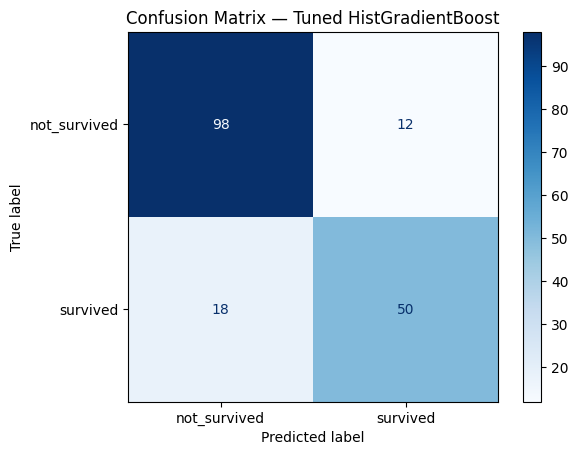

Hold-out ROC AUC: 0.836


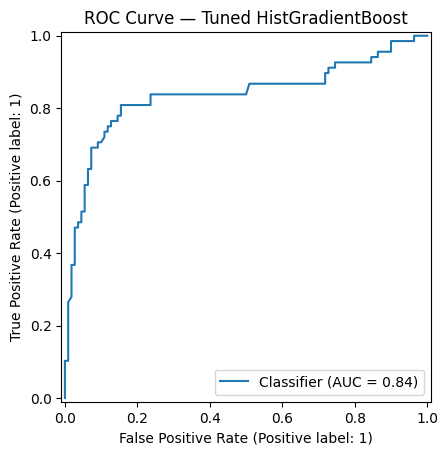

In [30]:
best_pipeline = grid_search.best_estimator_
best_model = best_pipeline.named_steps["model"]  # the HGB model itself

# Refit on full training set already done by GridSearchCV (refit=True default)
y_pred = best_pipeline.predict(X_test)

print("Classification report (hold-out):\n")
print(classification_report(y_test, y_pred, target_names=["not_survived", "survived"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["not_survived", "survived"]).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Tuned HistGradientBoost")
plt.show()

# ROC AUC & curve
if hasattr(best_pipeline, "predict_proba") or hasattr(best_pipeline.named_steps["model"], "predict_proba"):
    # HGB supports predict_proba
    y_proba = best_pipeline.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"Hold-out ROC AUC: {auc:.3f}")
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title("ROC Curve — Tuned HistGradientBoost")
    plt.show()
else:
    print("predict_proba not available for this pipeline.")

## 8) Permutation Importance (model-agnostic)
Permutation importance shuffles a feature's values to measure the decrease in model score — done on the hold-out set for realism.

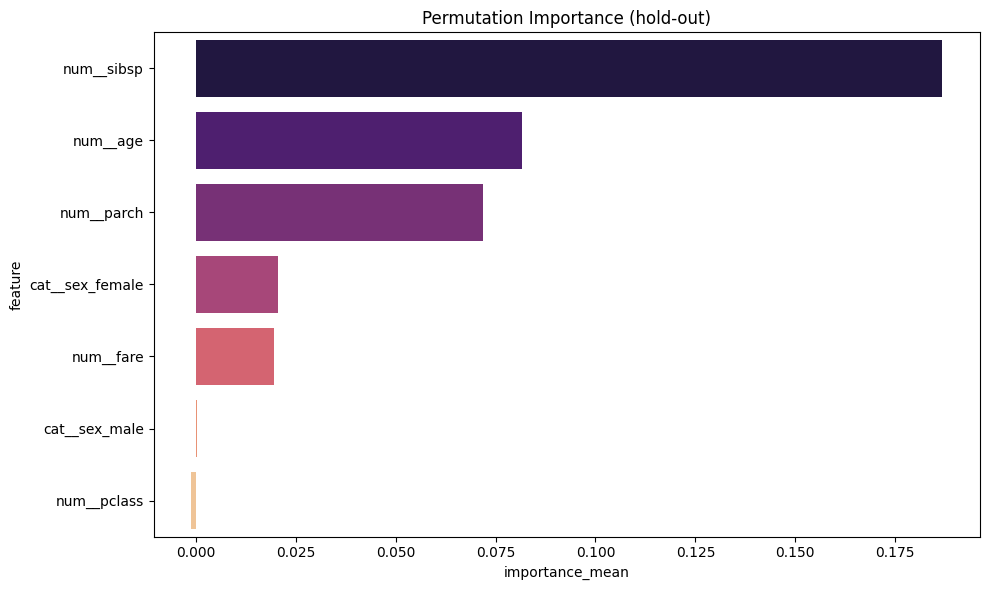

,feature,importance_mean,importance_std
1,num__sibsp,0.186798,0.023560
0,num__age,0.081742,0.012991
2,num__parch,0.071910,0.013483
5,cat__sex_female,0.020506,0.015208
3,num__fare,0.019663,0.011851
6,cat__sex_male,0.000281,0.006018
4,num__pclass,-0.001124,0.006051


In [31]:
# Run permutation importance
perm_res = permutation_importance(
    best_pipeline, X_test, y_test,
    n_repeats=20, random_state=SEED, n_jobs=-1
)

# Get feature names from preprocessor
feature_names = best_pipeline.named_steps["pre"].get_feature_names_out()

# Align feature names with actual number of features used by model
n_feats = perm_res.importances_mean.shape[0]
feature_names = feature_names[:n_feats]

# Build DataFrame
perm_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm_res.importances_mean,
    "importance_std": perm_res.importances_std
}).sort_values("importance_mean", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="importance_mean", y="feature", data=perm_df, palette="magma")
plt.title("Permutation Importance (hold-out)")
plt.tight_layout()
plt.show()

perm_df

## 10) SHAP — Global & Local explanations
**Install**: If you don't have `shap`, run `pip install shap`.  
We use SHAP to get per-sample explanations and overall feature impact.

**Note**: For tree models, SHAP's `TreeExplainer` is fast. We will use `shap.Explainer` which dispatches appropriately.

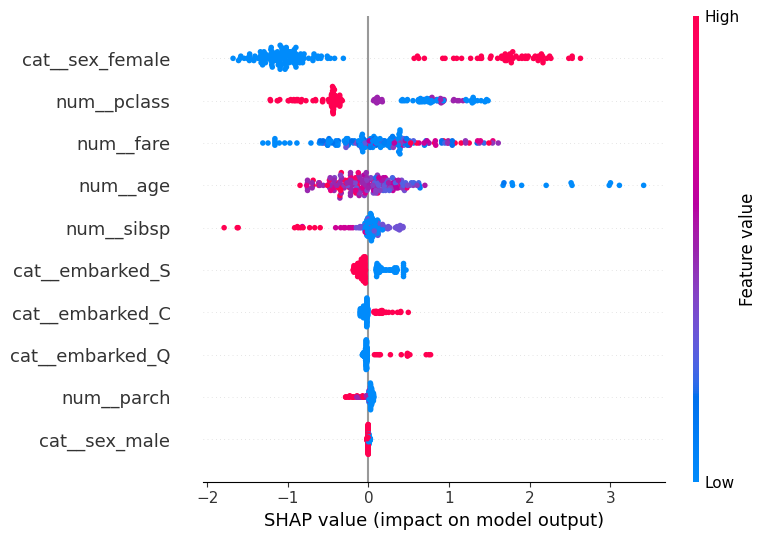

In [33]:
# If shap is not installed, warning
try:
    import shap
except Exception as e:
    raise RuntimeError("shap is required for this cell. Install with: pip install shap") from e

# Transform data (what the model actually sees)
X_train_trans = best_pipeline.named_steps["pre"].transform(X_train)
X_test_trans = best_pipeline.named_steps["pre"].transform(X_test)

# Align feature names with transformed data shape
n_feats = X_train_trans.shape[1]
feature_names = best_pipeline.named_steps["pre"].get_feature_names_out()[:n_feats]

# SHAP explainer
explainer = shap.Explainer(best_model, X_train_trans)
shap_values = explainer(X_test_trans, check_additivity=False)

# Global explanation
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, features=X_test_trans, feature_names=feature_names, show=True)

Test sample index: 0
True label: 0
Predicted prob: 0.07372178518118697


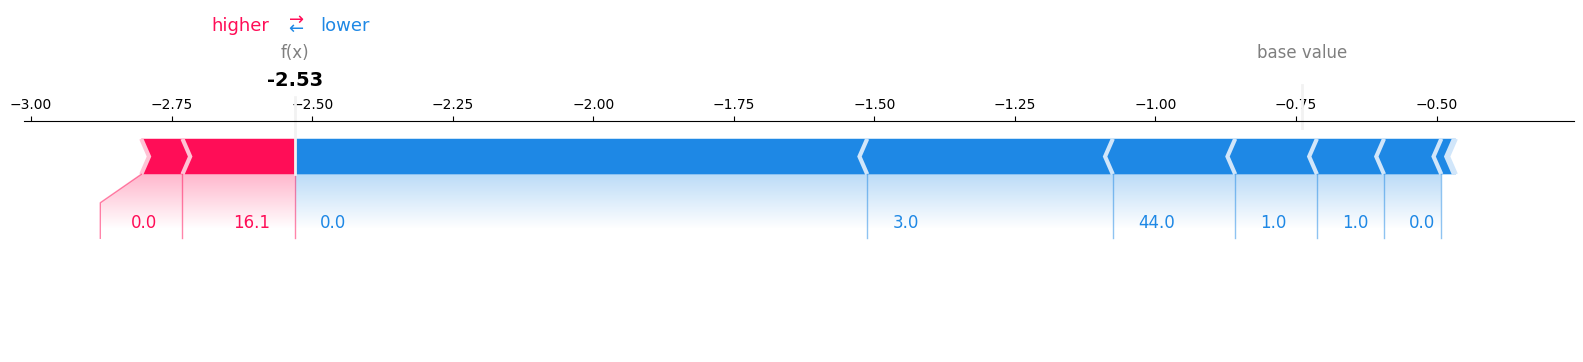

In [34]:
idx = 0  # choose a test sample
print("Test sample index:", idx)
print("True label:", y_test.iloc[idx])
print("Predicted prob:", best_pipeline.predict_proba(X_test)[idx,1])

shap_value_single = shap_values[idx]
shap.plots.force(shap_value_single, matplotlib=True, show=True)

## 11) Conclusion & Next steps
- We compared multiple classical models with consistent preprocessing and cross-validation.
- HistGradientBoosting was the strongest performer and was tuned with `GridSearchCV` to improve F1.
- On the hold-out test set, the tuned HGB achieved solid results (high F1 and AUC).
- Interpretability:
  - `feature_importances_` is **not available** for HistGradientBoosting, so we used **Permutation Importance** (model-agnostic).
  - **SHAP** was applied with `check_additivity=False` (a common workaround for HGB). This gave both global explanations (summary plot) and local explanations (force plots).

**Next steps to improve the project**
- Add engineered features (e.g., `family_size = sibsp + parch`, extract `title` from passenger names if using Kaggle CSV).
- Explore more extensive hyperparameter search (`RandomizedSearchCV`) or Bayesian optimization.
- Evaluate calibration (reliability diagrams), adjust classification thresholds, or test cost-sensitive learning.
- Try ensembles (stacking/blending) combining Logistic Regression, Random Forest, and HistGradientBoost.
- Package this notebook into a GitHub repo with `README`, `requirements.txt`, and example outputs for portfolio presentation.